In [1]:
import numpy as np 

In [111]:
def shuffle_function(X, y, nb, random_state = None) : #my shuffle isn't optimal at all 
  if type(nb) != int : 
    return 'nb must be an int'
  if random_state != None :
    rng = np.random.default_rng(seed = random_state)
    arr = rng.integers(X.shape[0], size = 2*nb)
  else :
    arr = np.random.randint(X.shape[0], size = 2*nb)
  for k in range(arr.shape[0] // 2) :
      aux1 = np.zeros(X.shape[1])
      aux2 = np.zeros(X.shape[1])
      for j in range(X.shape[1]) :
          aux1[j] = X[arr[k]][j]
          aux2[j] = X[arr[k + 1]][j]
      X[arr[k]] = aux2
      X[arr[k + 1]] = aux1
      if len(y.shape) == 1 :
        aux1 = y[arr[k]]
        aux2 = y[arr[k + 1]]
        y[arr[k]] = aux2
        y[arr[k+1]] = aux1
      else :
        aux1 = np.zeros(y.shape[1])
        aux2 = np.zeros(y.shape[1])
        for j in range(y.shape[1]) :
            aux1[j] = y[arr[k]][j]
            aux2[j] = y[arr[k + 1]][j]
        y[arr[k]] = aux2
        y[arr[k + 1]] = aux1
  return X, y

def splitter(X, y, test_size, random_state = None) :
  test_len = int(np.round(X.shape[0]*test_size))
  X_test = np.zeros((test_len, X.shape[1]))
  if len(y.shape) == 1 :
    y_test = np.zeros(test_len)
  else :
    y_test = np.zeros((test_len, y.shape[1])) 
  if random_state != None :
    rng = np.random.default_rng(seed = random_state)
    arr = rng.integers(X.shape[0], size = test_len)
    arr = np.unique(arr)
    while len(arr) < test_len :
      arr_2 = rng.integers(X.shape[0], size = test_len - len(arr) )
      arr = np.concatenate(arr, arr_2)
      arr = np.unique(arr)
  elif random_state == None :
    arr = np.random.randint(X.shape[0], size = test_len)
    arr = np.unique(arr)
    while len(arr) < test_len :
      arr_2 = np.random.randint(X.shape[0], size = test_len - len(arr) )
      arr = np.concatenate((arr, arr_2))
      arr = np.unique(arr)
  for k in range(test_len) :
    X_test[k, :] = X[arr[k], :]
    if len(y.shape) == 1:
        y_test[k] = y[arr[k]]
    else :
        y_test[k, :] = y[arr[k], :]
  arr = np.sort(arr)[::-1]
  for element in arr :
    X = np.delete(X, element, 0)
    y = np.delete(y, element, 0)
  X_train = X
  y_train = y
  return X_train, X_test, y_train, y_test

def train_test_split_multivariate_reg(X, y, test_size = None, shuffle = True, nb_shuffle = 4*X.shape[0], random_state = None) : 
  #we don't want to damage the original dataset
  X_copy = np.copy(X)
  y_copy = np.copy(y)
  if test_size == None :
    test_size = 0.25 #default value
  if shuffle == True :
    X_copy, y_copy = shuffle_function(X_copy, y_copy, nb_shuffle, random_state=random_state)
  X_train, X_test, y_train, y_test = splitter(X_copy, y_copy, test_size, random_state = random_state)
  return X_train, X_test, y_train, y_test 


In [182]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import time

In [113]:
iris = datasets.load_iris()
X = iris.data[:, :2] #we only take the first two features
y = iris.target  

In [201]:
class LogisticRegression: 
  def __init__(self, X, y) :
    self.X = X
    self.y = y

  def scale_data(self) :
    scaler = StandardScaler()
    self.X = scaler.fit_transform(self.X)
   
  def data_split(self, test_size = None) :
     self.X_train, self.X_test, self.y_train, self.y_test = train_test_split_multivariate_reg(self.X, self.y, test_size = test_size)

  def add_intercept(self) :
     intercept = np.ones((self.X_train.shape[0], 1))
     self.X_train = np.concatenate((intercept, self.X_train), axis = 1)
     intercept = np.ones((self.X_test.shape[0], 1))
     self.X_test = np.concatenate((intercept, self.X_test), axis = 1)
  
  def encoded_y(self):
    k = len(set(self.y))
    y_train_encoded = np.zeros((self.X_train.shape[0], k))
    for each_class in range(k) :
      cond = self.y_train == each_class
      y_train_encoded[np.where(cond), each_class] = 1
    self.y_train = y_train_encoded

  def h_theta(self, x, w) :
    return self.softmax(x @ w)

  def softmax(self, x):
    if len(x.shape) == 1 :
      return np.exp(x)/ np.sum(np.exp(x))
    else :
      return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

  def softmax_grad(self, X, error) :
    return X.T @ error 

  def gradient(self, X, y, w) :
    h = self.h_theta(X, w)
    cost = -np.sum(y * np.log(h))
    error = h - y
    grad = self.softmax_grad(X, error)
    return cost, grad
  
  def gradient_descent(self, X, y, max_iter, method) :
    if method not in ['minibatch', 'batch', 'sto'] :
      raise ValueError('method must be minibatch, batch or sto')
    if method == 'minibatch' :
            w = np.random.rand(X.shape[1], y.shape[1])
            cost_per_iter = []
            l_rate = 0.01
            #10% of data
            batch_size = int(0.1 * X.shape[0])
            for i in range(max_iter):
              ix = np.random.randint(0, X.shape[0]) 
              batch_X = X[ix:ix+batch_size]
              batch_y = y[ix:ix+batch_size]
              cost, grad = self.gradient(batch_X, batch_y, w)
              cost_per_iter.append(cost)
              w = w - l_rate * grad
            self.cost_per_iter = cost_per_iter
            self.iter = max_iter
            self.w = w
    elif method == 'batch' :
            w = np.random.rand(X.shape[1], y.shape[1])
            cost_per_iter = []
            l_rate = 0.01
            for i in range(max_iter):
              cost, grad = self.gradient(X, y, w)
              cost_per_iter.append(cost)
              w = w - l_rate * grad
            self.cost_per_iter = cost_per_iter
            self.iter = max_iter
            self.w = w
    elif method == 'sto' :
            w = np.random.rand(X.shape[1], y.shape[1])
            cost_per_iter = []
            l_rate = 0.01
            for i in range(max_iter): 
              j = np.random.randint(0, X.shape[0])
              cost, grad = self.gradient(X[j], y[j], w)
              cost_per_iter.append(cost)
              w = w - l_rate * grad
            self.cost_per_iter = cost_per_iter
            self.iter = max_iter
            self.w = w
    
  def plot_cost(self):
      x = np.arange(self.iter)
      plt.plot(x, self.cost_per_iter, color='b')
      plt.xlabel('iterations')

      plt.ylabel('cost')
      plt.show()

  def output(self):
    return np.argmax(self.h_theta(self.X_test, self.w), axis = 1)

In [176]:
exp = LogisticRegression(X, y)
exp.scale_data()
exp.data_split(test_size = 0.3)
exp.encoded_y()
exp.add_intercept()

In [180]:
exp.gradient_descent(exp.X_train, exp.y_train, max_iter = 10000, method = 'method')

ValueError: ignored

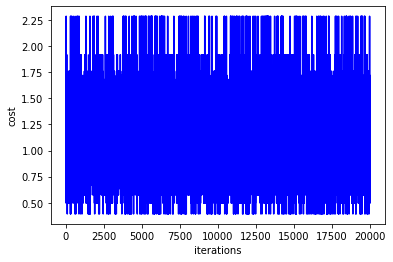

In [202]:
t1_sto = time.time()
exp.gradient_descent(exp.X_train, exp.y_train, max_iter = 20000, method = 'sto')
t2_sto = time.time()
time_sto = t2_sto - t1_sto 
exp.plot_cost()
y_predicted_sto = exp.output()

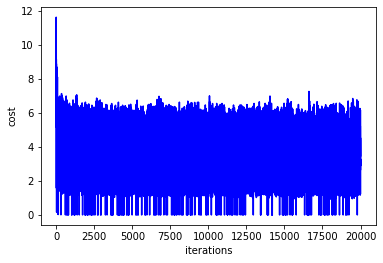

In [196]:
t1_minibatch = time.time()
exp.gradient_descent(exp.X_train, exp.y_train, max_iter = 20000, method = 'minibatch')
t2_minibatch = time.time()
time_minibatch = t2_minibatch- t1_minibatch
exp.plot_cost()
y_predicted_minibatch = exp.output()

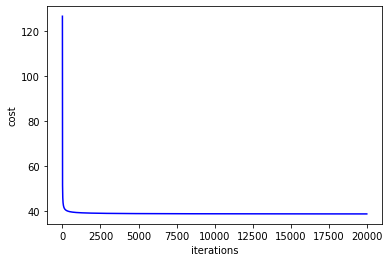

In [195]:
t1_batch = time.time()
exp.gradient_descent(exp.X_train, exp.y_train, max_iter = 20000, method = 'batch')
t2_batch = time.time()
time_batch = t2_batch- t1_batch
exp.plot_cost()
y_predicted_batch = exp.output()

In [211]:
print('stochastic method time : ', time_sto, ' seconds')
print('minibatch method time : ', time_minibatch, ' seconds')
print('batch method time : ', time_batch, '  seconds')

stochastic method time :  0.6262118816375732  seconds
minibatch method time :  0.7548904418945312  seconds
batch method time :  1.0344877243041992   seconds


In [190]:
from sklearn.metrics import classification_report

In [198]:
print(classification_report(exp.y_test, y_predicted_sto))

              precision    recall  f1-score   support

         0.0       0.34      1.00      0.51        14
         1.0       0.75      0.18      0.29        17
         2.0       0.00      0.00      0.00        14

    accuracy                           0.38        45
   macro avg       0.36      0.39      0.26        45
weighted avg       0.39      0.38      0.27        45



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [199]:
print(classification_report(exp.y_test, y_predicted_minibatch))

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96        14
         1.0       0.72      0.76      0.74        17
         2.0       0.71      0.71      0.71        14

    accuracy                           0.80        45
   macro avg       0.81      0.80      0.81        45
weighted avg       0.81      0.80      0.80        45



In [200]:
print(classification_report(exp.y_test, y_predicted_batch))

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96        14
         1.0       0.72      0.76      0.74        17
         2.0       0.71      0.71      0.71        14

    accuracy                           0.80        45
   macro avg       0.81      0.80      0.81        45
weighted avg       0.81      0.80      0.80        45



As the reports show us, the mini_batch and the batch gradient descent methods are the most accurate. Indeed, for 20000 iterations of gradient descent algorithm, the minibatch and the batch method give similar results (if we make lower iterations, as we can predict, the batch method is more accurate than the minibatch method). Even if the stochastic method gives, for this dataset, results far from the reality, it is this method that is the fastest (followed by the minibatch and the batch method). Because our lab's dataset size isn't immense, the batch method seems to be the best for prediction. However, if the dataset grows, the batch method will probably take too much time to converge to a result. So, the minibatch which gives compelling results could be a good compromise. For me, it is the minibatch method that provides the most astonishing results. Effectively, for a time execution close to the stochastic, the minibatch method gives the same results that the batch method (usually the most accurate)! To conclude, in this lab, we see the limits of the stochastic method (maybe it is me who didn't implement it well ... ) and the achievement of the minibatch methods.  